# accessing data

In [1]:
#!ls
#!pip install pandas
#!pip install scikit-learn

In [2]:
import pandas as pd

df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/FPA-FOD_reduced.csv", low_memory = False)
df = df.drop('Unnamed: 0', axis = 'columns') #drops the items where columns are unnamed


FileNotFoundError: [Errno 2] No such file or directory: '/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/FPA-FOD_reduced.csv'

# Processing data

In [4]:
unknown_mask = df['NWCG_GENERAL_CAUSE'] == "Missing data/not specified/undetermined"

df_known = df[~unknown_mask].copy()
df_unknown = df[unknown_mask].copy()

In [5]:
X = df_known.drop(columns=['NWCG_GENERAL_CAUSE'])
y = df_known['NWCG_GENERAL_CAUSE']

In [6]:
X = X.fillna(X.median(numeric_only=True)) #replace NANs

for col in X.columns: #convert numeric values to floats, if possible
    if X[col].dtype == 'object':
        # try converting to float — if it works, keep it numeric
        try:
            X[col] = X[col].astype(float)
        except ValueError:
            pass


In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y) #encode the textual output

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_features = ['pr', 'tmmn', 'tmmx', 'rmin', 'rmax', 'sph', 'srad', 'etr', 'vpd',
                    'bi', 'erc', 'fm100', 'fm1000', 'EVC', 'EVT', 'EVH',
                    'Elevation', 'Slope', 'Aspect', 'TRI', 'TPI', 'Aridity_index',
                    'Population', 'GDP', 'LATITUDE', 'LONGITUDE', 'FIRE_YEAR','DISCOVERY_DOY', 'DISCOVERY_TIME']

categorical_features = ['STATE', 'COUNTY']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split train test

In [9]:
from sklearn.model_selection import train_test_split

# Combine X and y into one DataFrame temporarily
df2 = X.copy()
df2['cause'] = y_encoded

df_balanced = (
    df2.groupby('cause', group_keys=False)
      .apply(lambda x: x.sample(n=min(len(x), 10000), random_state=42))
      .reset_index(drop=True)
)

# Split back into X and y
X_balanced = df_balanced.drop(columns=['cause'])
y_balanced = df_balanced['cause']

# Now do your train-test split as usual
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(X_train_df.shape, X_test_df.shape)
print(y_train_df.value_counts())

/var/folders/9p/1xc4qsqs6wv7ng86fqksqfrr0000gn/T/ipykernel_44296/1772595633.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2.groupby('cause', group_keys=False)


(90186, 32) (22547, 32)
cause
11    8000
6     8000
10    8000
8     8000
0     8000
7     8000
2     8000
4     8000
1     8000
5     8000
9     8000
3     2186
Name: count, dtype: int64


In [10]:
cause_names = [
    "Debris and open burning",
    "Misuse of fire by a minor",
    "Equipment and vehicle use",
    "Fireworks",
    "Arson/incendiarism",
    "Power generation/transmission/distribution",
    "Railroad operations and maintenance",
    "Recreation and ceremony",
    "Natural",
    "Smoking",
    "Other causes",
    "Firearms and explosives use"
]

# Convert y_train value counts into a DataFrame for easier mapping
counts = y_train_df.value_counts().reset_index()
counts.columns = ['cause_id', 'count']

# Map encoded ID to name
counts['cause_name'] = counts['cause_id'].map(lambda i: cause_names[i])

print(counts[['cause_id', 'cause_name', 'count']].to_string(index=False))

 cause_id                                 cause_name  count
       11                Firearms and explosives use   8000
        6        Railroad operations and maintenance   8000
       10                               Other causes   8000
        8                                    Natural   8000
        0                    Debris and open burning   8000
        7                    Recreation and ceremony   8000
        2                  Equipment and vehicle use   8000
        4                         Arson/incendiarism   8000
        1                  Misuse of fire by a minor   8000
        5 Power generation/transmission/distribution   8000
        9                                    Smoking   8000
        3                                  Fireworks   2186


In [12]:
X_train_df.head()

,pr,tmmn,tmmx,rmin,rmax,sph,srad,etr,vpd,bi,...,Aridity_index,Population,GDP,LATITUDE,LONGITUDE,STATE,COUNTY,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME
112173,0.0,289.299988,305.600006,34.500000,78.099998,0.01047,279.000000,5.9,1.68,22.0,...,0.75,0.0380,29129.756,33.172944,-89.923202,MS,Holmes,1995,250,1400.0
104451,0.0,287.600006,303.399994,32.100002,95.700005,0.01010,256.300018,6.7,1.35,32.0,...,0.73,0.0000,67082.420,39.770000,-74.679000,NJ,Burlington,2015,249,2300.0
57302,3.6,295.299988,308.600006,38.400002,100.000000,0.01639,357.899994,8.2,1.56,0.0,...,0.42,0.0000,50895.010,29.821390,-81.520000,FL,St. Johns,2006,217,1600.0
100210,0.0,273.200012,286.600006,24.100000,63.200001,0.00276,216.400009,3.8,0.67,33.0,...,0.26,0.0042,45981.348,47.647800,-114.345600,MT,NaN,2020,82,2200.0
74912,0.0,274.600006,283.399994,36.400002,66.200005,0.00310,258.899994,5.3,0.49,59.0,...,0.78,0.0150,42784.630,46.262150,-89.783430,WI,Vilas,2010,106,1342.0


In [13]:
y_train_df.head()

112173    11
104451    11
57302      6
100210    10
74912      8
Name: cause, dtype: int64

## you can start from here really

### Standardizazion

In [80]:
import torch

X_train_df = pd.read_csv("datasets/X_train_df.csv")
y_train_df = pd.read_csv("datasets/y_train_df.csv")
X_test_df = pd.read_csv("datasets/X_test_df.csv")
y_test_df = pd.read_csv("datasets/y_test_df.csv")


# Standardization
X_train_df = X_train_df.select_dtypes(include=['number'])
y_train_df = y_train_df.select_dtypes(include=['number'])
X_test_df = X_test_df.select_dtypes(include=['number'])
y_test_df = y_test_df.select_dtypes(include=['number'])

mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

y_train_df = pd.get_dummies(y_train_df['cause']).astype(float) #turns the training data from one column for categories into one column for each with probability
y_train_df.head()
y_test_df = pd.get_dummies(y_test_df['cause']).astype(float) #turns the training data from one column for categories into one column for each with probability

### Make data NN ready

In [81]:



X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

X_test = X_test_df.to_numpy()


# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), \
                                               torch.FloatTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test))


# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


# Neural Network

In [82]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cwd = os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
# set hyperparameters
n_neuron       = 64
activation     = 'ReLU' #'ReLU' #'Linear', 'Tanh'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
N_layers       = 2 # number of hidden layers

In [84]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [85]:
layers = []
layers.append(nn.Linear(X_train.shape[1], n_neuron))
layers.append(getattr(nn, activation)())

for n in range(N_layers-1):
   layers.append(nn.Linear(n_neuron, n_neuron))
   layers.append(getattr(nn, activation)())

layers.append(nn.Linear(n_neuron, y_train.shape[1]))

model = nn.Sequential(*layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [86]:
print(model)

Sequential(
  (0): Linear(in_features=29, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=12, bias=True)
)


In [87]:
model.to(device)

Sequential(
  (0): Linear(in_features=29, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=12, bias=True)
)

In [88]:
best_val_loss = float('inf')
patience_counter = 0
patience = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
   # training
   model.train()
   train_loss = 0.0
   for batch_X, batch_y in train_loader:
       batch_X = batch_X.to(device)
       batch_y = batch_y.to(device)
       # forward pass
       optimizer.zero_grad()
       outputs = model(batch_X)
       loss = criterion(outputs, batch_y)
       # backward pass
       loss.backward()
       optimizer.step()
       train_loss += loss.item()

    # validation
   model.eval()
   val_loss = 0.0
   with torch.no_grad():
       for batch_X, batch_y in val_loader:
           batch_X = batch_X.to(device)
           batch_y = batch_y.to(device)
           
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           val_loss += loss.item()
   
   train_loss /= len(train_loader)
   val_loss /= len(val_loader)

   train_losses.append(train_loss)
   val_losses.append(val_loss)
   
   print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
   
   if val_loss < best_val_loss:
       best_val_loss = val_loss
       patience_counter = 0
   else:
       patience_counter += 1
       if patience_counter >= patience:
           print(f'Early stopping at epoch {epoch+1}')
           break

Epoch 1/50, Train Loss: 0.0684, Val Loss: 0.0659
Epoch 2/50, Train Loss: 0.0649, Val Loss: 0.0645
Epoch 3/50, Train Loss: 0.0638, Val Loss: 0.0638
Epoch 4/50, Train Loss: 0.0632, Val Loss: 0.0635
Epoch 5/50, Train Loss: 0.0628, Val Loss: 0.0632
Epoch 6/50, Train Loss: 0.0625, Val Loss: 0.0629
Epoch 7/50, Train Loss: 0.0623, Val Loss: 0.0629
Epoch 8/50, Train Loss: 0.0620, Val Loss: 0.0629
Epoch 9/50, Train Loss: 0.0618, Val Loss: 0.0625
Epoch 10/50, Train Loss: 0.0616, Val Loss: 0.0625
Epoch 11/50, Train Loss: 0.0614, Val Loss: 0.0623
Epoch 12/50, Train Loss: 0.0612, Val Loss: 0.0622
Epoch 13/50, Train Loss: 0.0611, Val Loss: 0.0621
Epoch 14/50, Train Loss: 0.0609, Val Loss: 0.0619
Epoch 15/50, Train Loss: 0.0608, Val Loss: 0.0618
Epoch 16/50, Train Loss: 0.0607, Val Loss: 0.0617
Epoch 17/50, Train Loss: 0.0606, Val Loss: 0.0617
Epoch 18/50, Train Loss: 0.0605, Val Loss: 0.0617
Epoch 19/50, Train Loss: 0.0604, Val Loss: 0.0616
Epoch 20/50, Train Loss: 0.0604, Val Loss: 0.0617
Epoch 21/

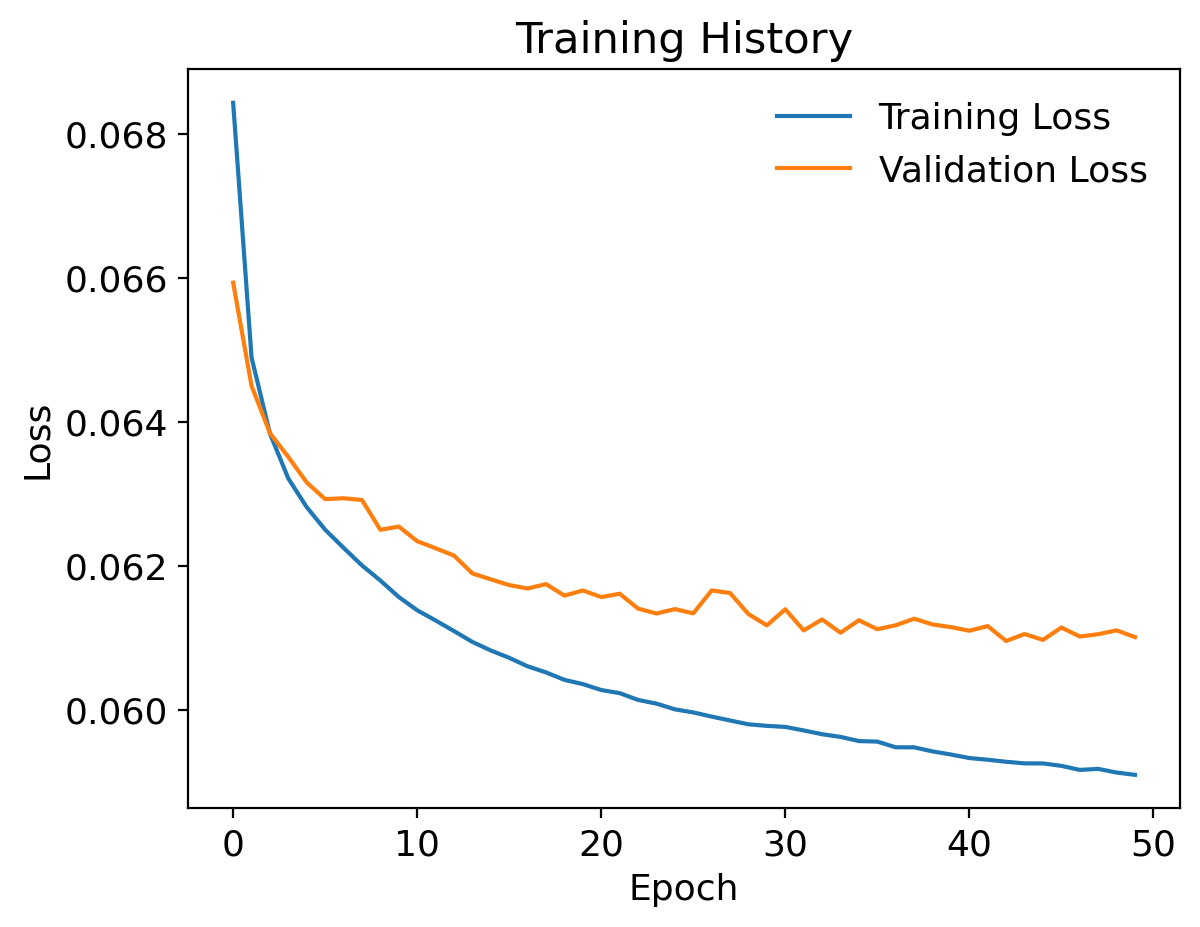

In [89]:
plot_history(train_losses, val_losses)

In [90]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [91]:
# Save the entire model to a pth file.
torch.save(model, os.path.join(model_path, 'NN_model.pth'))

In [99]:
# reload the saved model
model = torch.load(os.path.join(model_path, 'NN_model.pth'), weights_only=False)
model.to(device).eval()

Sequential(
  (0): Linear(in_features=29, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=12, bias=True)
)

In [107]:
# After prediction and concatenation
y_test_pre = np.concatenate(predictions, axis=0)  # shape (num_samples, 12)

cause_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
y_pred_df = pd.DataFrame(y_test_pre, columns=cause_names)

In [108]:
y_test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Calculate RMSE

In [109]:
import numpy as np

# Flatten the DataFrames to 1D arrays (optional but commonly done)
true_values = y_test_df.values.flatten()
pred_values = y_pred_df.values.flatten()

# Calculate RMSE
rmse = np.sqrt(np.mean((true_values - pred_values) ** 2))
print(f'RMSE: {rmse}')


RMSE: 0.2471252171144261


# Make Confusion Matrix

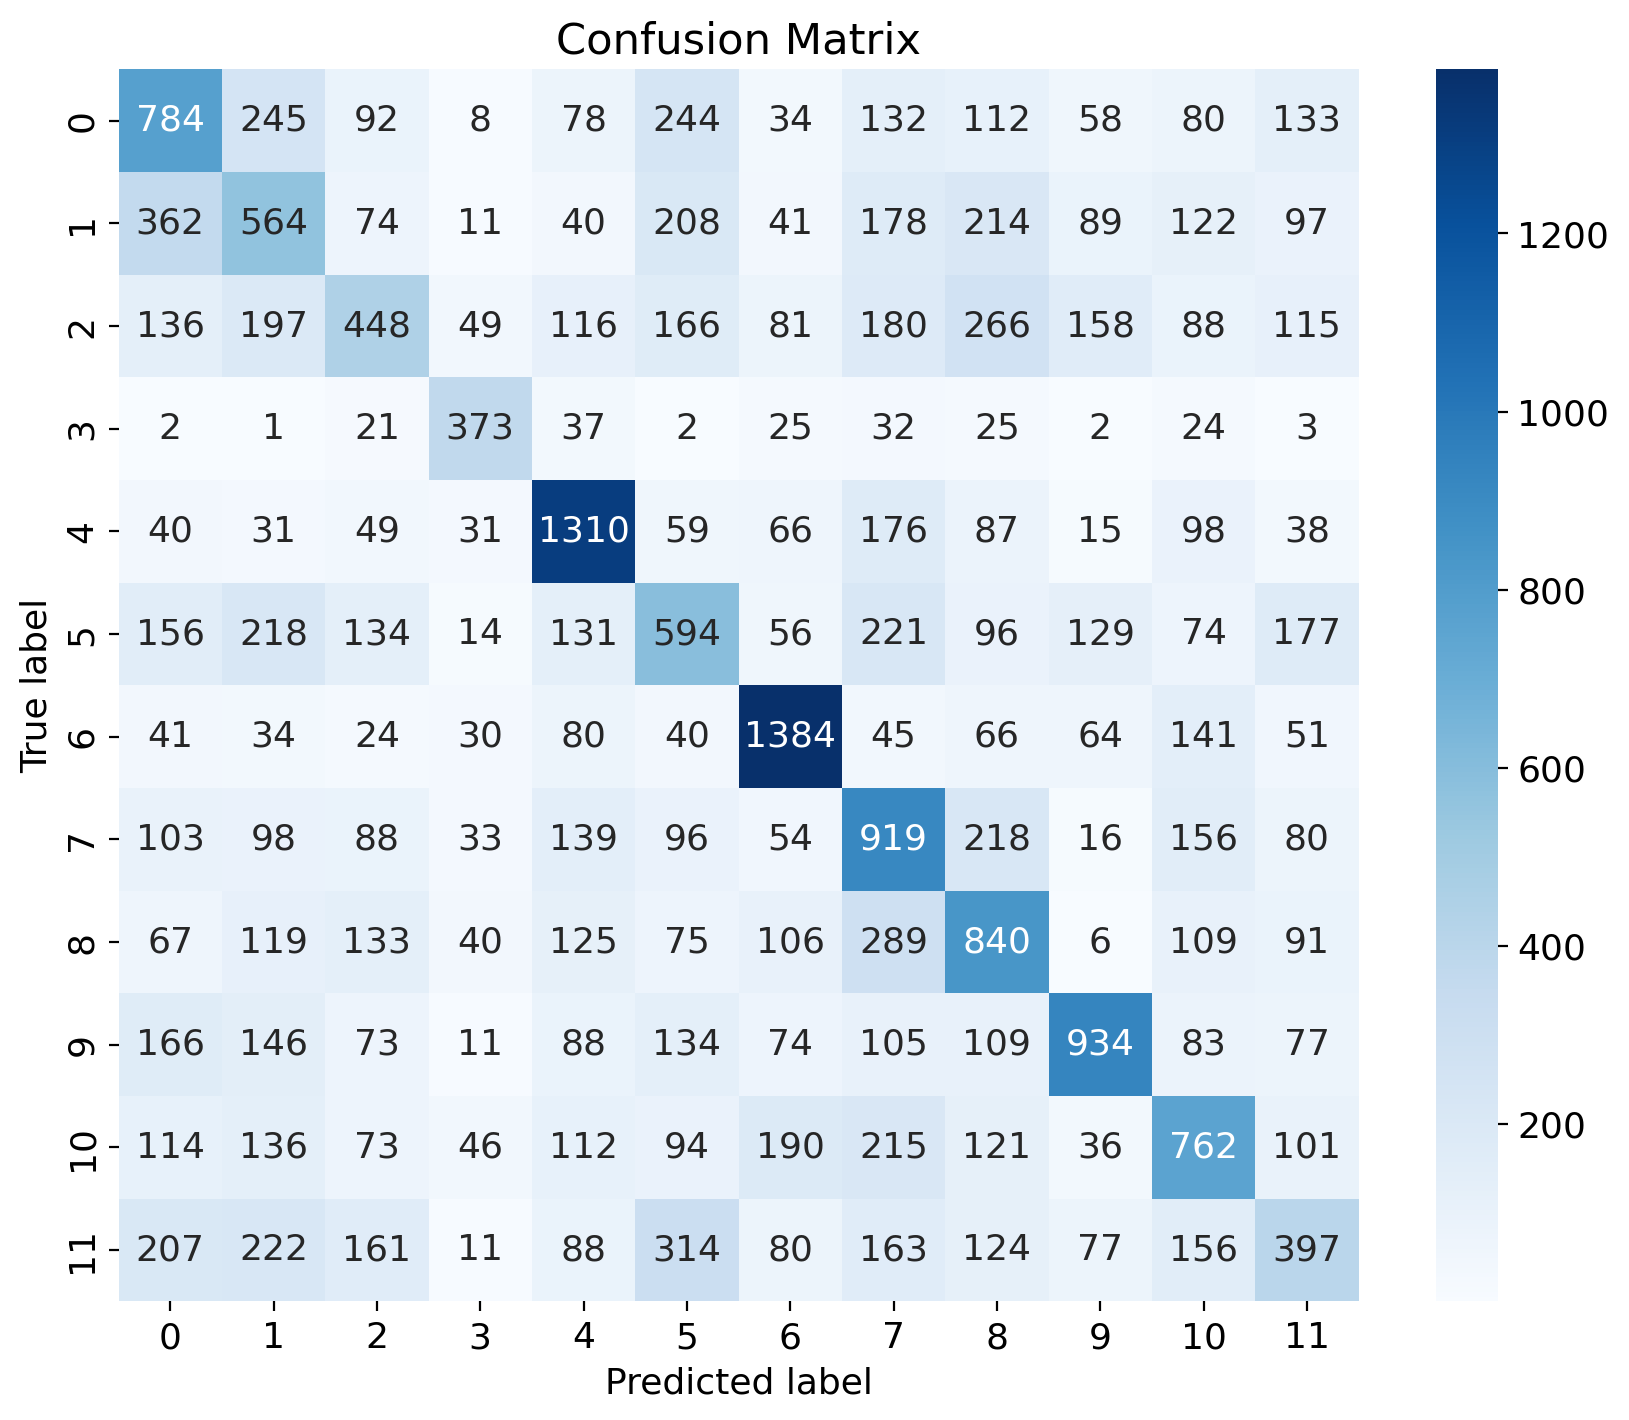

In [110]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# y_test_df and y_pred_df are your dataframes of shape (samples, 12)
# Each row: probabilistic assignment to each cause

# Get true and predicted cause labels by argmax across columns
y_true = np.argmax(y_test_df.values, axis=1)
y_pred = np.argmax(y_pred_df.values, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(12))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
